### Initializations

In [53]:

expt_path='C:\\_Data\\LLqub2\\Tuning_2024_09_04\\'

#cfg_file = 'coherence2405.yml'
cfg_file = 'autocalibration_cfg_mp2.yml'
#expt_path='C:\\_Data\\LLqub2\\Tuning_2024_05_12\\'
#cfg_file = 'autocalibration_cfg.yml'


%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


from qick import *

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D
# for adding code snippets in loop exec_before/exec_after
from qick.asm_v2 import AsmV2

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import os
import sys
import json
import cProfile

from scipy.fft import fft, fftfreq

from slab.instruments.instrumentmanager import InstrumentManager
#from slab.instruments.instrumenttypes import Instrument
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
import experiments as meas
import autocalib_config as cfg

import config

# Figure params
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams.update({'font.size': 13})


print('Data will be stored in', expt_path)

import importlib 
importlib.reload(meas)

# Results config file:
cfg_path = os.getcwd() + '\\' + cfg_file
#print('Results config will be', cfg_path)
#cfg_path = expt_path + cfg_file
cfg_file = cfg_path 
auto_cfg = config.load(cfg_path)

auto_cfg

# Connect to instruments 
im = InstrumentManager(ns_address='192.168.137.1') # BF5

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())

num_qubits = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data will be stored in C:\_Data\LLqub2\Tuning_2024_09_04\
imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.crud
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.rb_ziqian
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.single_shot


Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

In [54]:
auto_cfg = config.load(cfg_path)

auto_cfg

{'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick233'},
 'device': {'qubit': {'T1': [103.62305539086516,
    52.68281995548557,
    154.69004863925176,
    38.74833436176555,
    186.5715524275808,
    109.9181405946411],
   'T2r': [100, 100, 100, 100, 100, 100],
   'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000],
   'f_ef': [3409.1880528279153,
    3391.493521164582,
    3346.8834162672324,
    3168.249198914187,
    3100.5188896758013,
    3084.4265735415747],
   'f_ge': [3569.4246,
    3553.6547824956374,
    3534.397712856832,
    3548.8138036767286,
    3615.77056431344,
    2700.32],
   'kappa': [0.0714,
    1.0034148512971155,
    -0.07023398468600771,
    -0.05743716663987561,
    0.1391475234765866,
    -0.009554968285355604],
   'pulses': {'hpi_ge': {'gain': [500, 500, 500, 500, 500, 500],
     'sigma': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
     'type': ['gauss', 'gauss', 'gauss', 'gauss', 'gauss', 'gauss']},
    'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000],
     

### Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

generator 2 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 2, but it's not multiplexed and doesn't have a mixer, so it will do nothing


200 307
readout freq 0 +/- 7102.20705870269


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_09_04\00007_adc_trig_offset_calibration_qubit0.h5


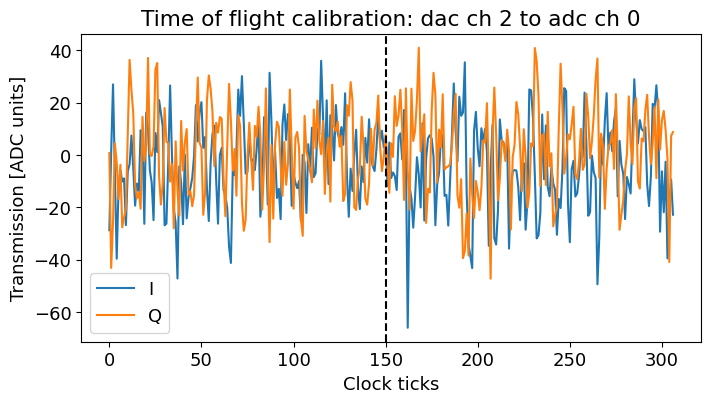

In [67]:
i = 0
tof = cfg.make_tof(soc, expt_path, cfg_path, i, im=im, go=True)

## Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

### Coarse 

In [68]:
#rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=6000, span=800, reps=2000, npts=5000)
rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=7001.1, span=300, reps=100, npts=1000)
rspec.go(analyze=False, display=False, progress=True, save=True)

rspec.analyze(fit=False, coarse_scan = True)
rspec.display(fit=False, coarse_scan = True)
res_values = rspec.data['coarse_peaks']

  0%|          | 0/1000 [00:00<?, ?it/s]

generator 2 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 2, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 0 doesn't have a digital mixer, but mixer_freq was defined


TypeError: unsupported operand type(s) for <<: 'float' and 'int'

In [ ]:
# Optional, play around with the finding peaks: 
rspec.analyze(fit=False, coarse_scan = True)
rspec.display(fit=False, coarse_scan = True)
res_values = rspec.data['coarse_peaks']

### Fine

In [69]:
# Fine, going through list of res values 
#for i in range(len(res_values)):
for i in range(1):
    if i<num_qubits: qubit_i=i
    else: qubit_i=0
    # Next, run the fine scan for each to make sure they are good. 
    rspec = cfg.make_rspec_fine(soc, expt_path, cfg_path, qubit_i, im=im, smart=False) #center=res_values[i], smart=False)
#    rspec.go(analyze=True, display=True, progress=True, save=True)
    #if i<num_qubits:
        #auto_cfg = config.update_readout(cfg_file, 'frequency', round(float(rspec.data['fit'][0]),4), i)
        #auto_cfg = config.update_readout(cfg_file, 'kappa', round(float(rspec.data['kappa']),4), i)

  0%|          | 0/200 [00:00<?, ?it/s]

generator 2 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 2, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 0 doesn't have a digital mixer, but mixer_freq was defined


TypeError: unsupported operand type(s) for <<: 'float' and 'int'

  0%|          | 0/200 [00:00<?, ?it/s]

generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital

[102.39455870269, 50000, 10000, 0, 13.203897544012731, 13.149219595021782, 0.2823997610965702]
[ 1.02504896e+02  3.43280354e+04  5.59343927e+04 -2.01985882e+01
  9.16894872e+00  9.71358117e+00  5.43538940e-01]

Freq with minimum transmission: 102.15705870269
Freq with maximum transmission: 102.88205870268999
From fit:
	f0: 102.5048963557265
	Qi: 34328.03538849369
	Qe: 55934.39269667616
	Q0: 21272.61422785588
	kappa [MHz]: 0.00481863184551616
	phi [radians]: -20.198588161813365
Saving C:\_Data\LLqub2\Tuning_2024_09_04\00005_resonator_spectroscopy_res0.h5


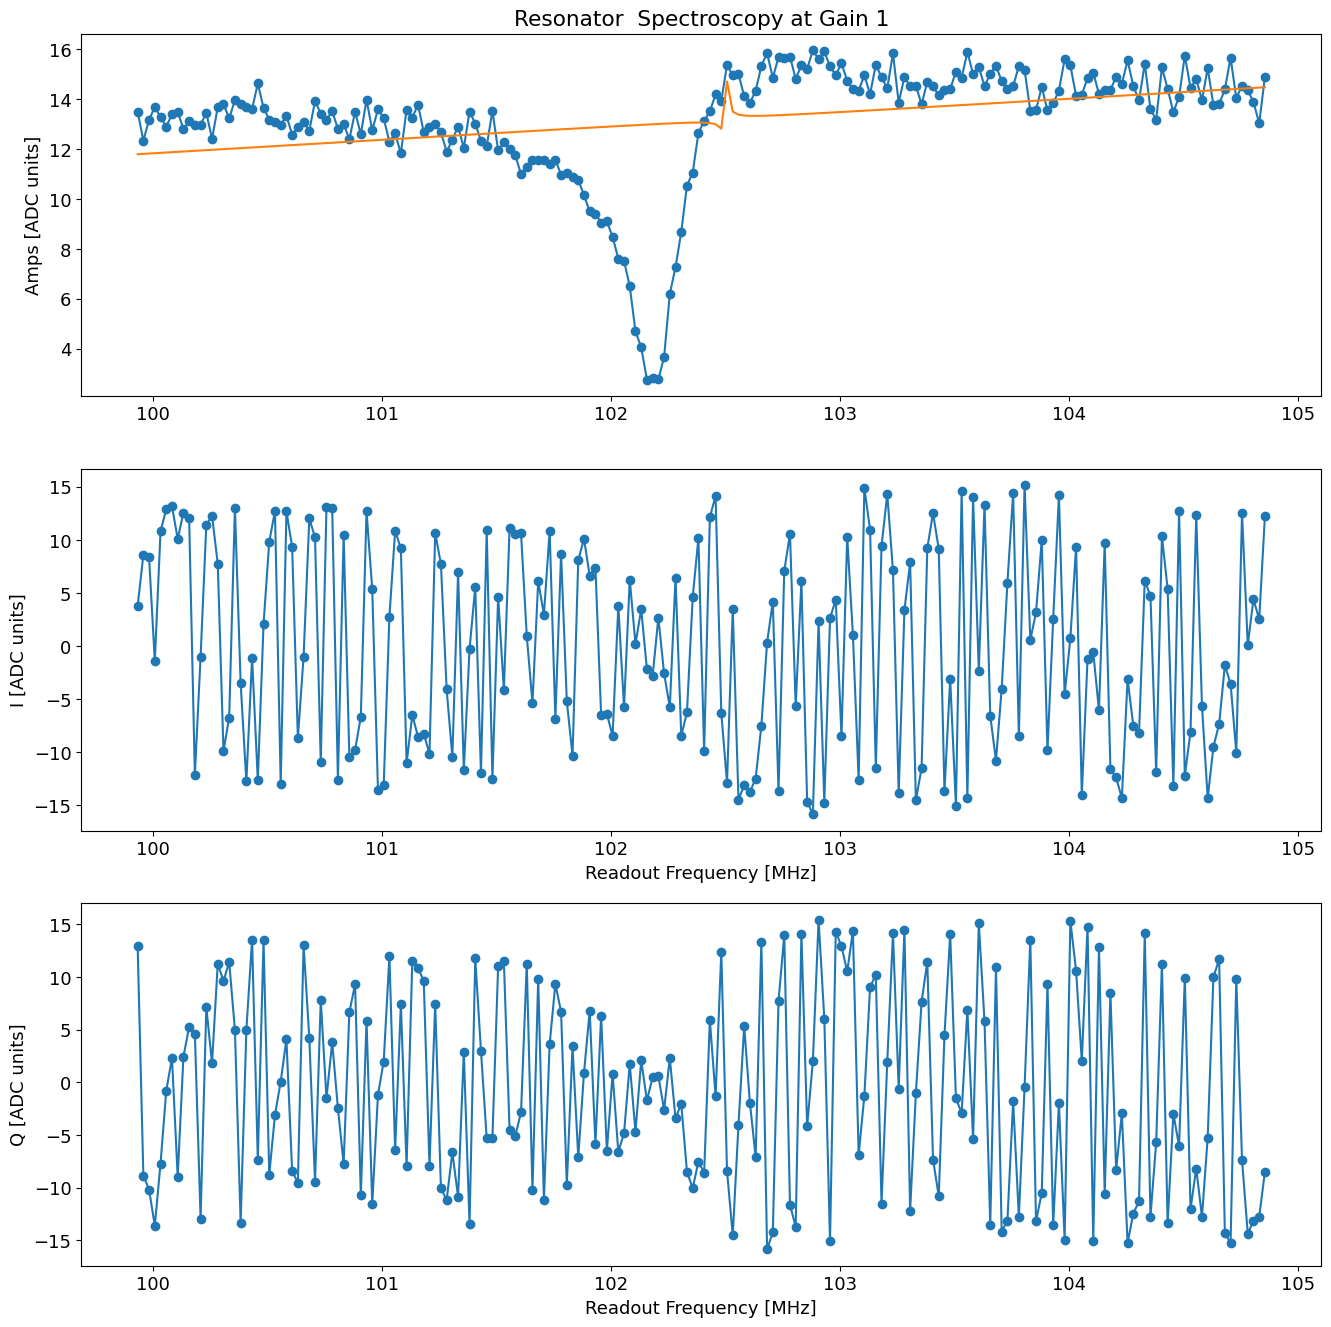

In [22]:
# Just run one  
i = 0
#config.update_readout(cfg_file, 'gain', 4000, i)

rspec = cfg.make_rspec_fine(soc, expt_path, cfg_path, i, im=im, smart=False, span=5)
#auto_cfg = config.update_readout(cfg_file, 'frequency', round(float(rspec.data['fit'][0]),4), i)
#auto_cfg = config.update_readout(cfg_file, 'kappa', round(float(2*rspec.data['kappa']),4), i)

In [8]:
auto_cfg = config.update_readout(cfg_file, 'kappa', 0, i)

#[7099.40705870269, 7139.0071872378885, 7146.234620965896, 7212.577818704508,
      7216.820553218962, 7251.331222083031]

[99.40705870269, 139.0071872378885, 146.234620965896, 212.577818704508,
      216.820553218962, 251.331222083031]

*Set cfg resonator 0 kappa to 0 from 0.2802765245445858*


If you are okay with the peaks, save data to <code>auto_cfg.device.readout.frequency</code>

### Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

In [ ]:
i=3
rpowspec=cfg.make_rpowspec(soc, expt_path, cfg_path, i, auto_cfg['device']['readout']['frequency'][i], npts_f=500, npts_gain=20, start_gain=50, span_gain=5000, smart=True, reps=2000)
rpowspec.go(analyze=False, display=False, progress=True, save=True)

# Testing 
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [ ]:
# assign the resonator gain to the results config file
gain_values = [12000, 4000, 8000, 6000, 8750, 8000]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

## Qubit Spectroscopy

### Coarse

High power and wide

generator 0 doesn't have a digital mixer, but mixer_freq was defined


Running qubit spectroscopy for qubit 0


  0%|          | 0/20 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_09_04\00000_qubit_spectroscopy_coarse_qubit0.h5
Found peak in amps at [MHz] 3185.3463293956875
Found peak in amps at [MHz] 3214.146329395687
Found peak in amps at [MHz] 3247.7463293956876
Found peak in amps at [MHz] 3281.3463293956875
Found peak in amps at [MHz] 3311.7463293956876
Found peak in amps at [MHz] 3341.0796627290206
Found peak in amps at [MHz] 3371.4796627290207
Found peak in amps at [MHz] 3431.2129960623543
Found peak in amps at [MHz] 3465.3463293956875
Found peak in amps at [MHz] 3502.6796627290205
Found peak in amps at [MHz] 3534.146329395687
Found peak in amps at [MHz] 3563.4796627290207
Found peak in amps at [MHz] 3596.012996062354
Found peak in amps at [MHz] 3629.0796627290206
Found peak in amps at [MHz] 3656.279662729021
Found peak in amps at [MHz] 3705.8796627290208
Found peak in amps at [MHz] 3752.812996062354
Found peak in amps at [MHz] 3789.612996062354
Found peak in amps at [MHz] 3839.2129960623543
Found peak in amps at [MHz] 38

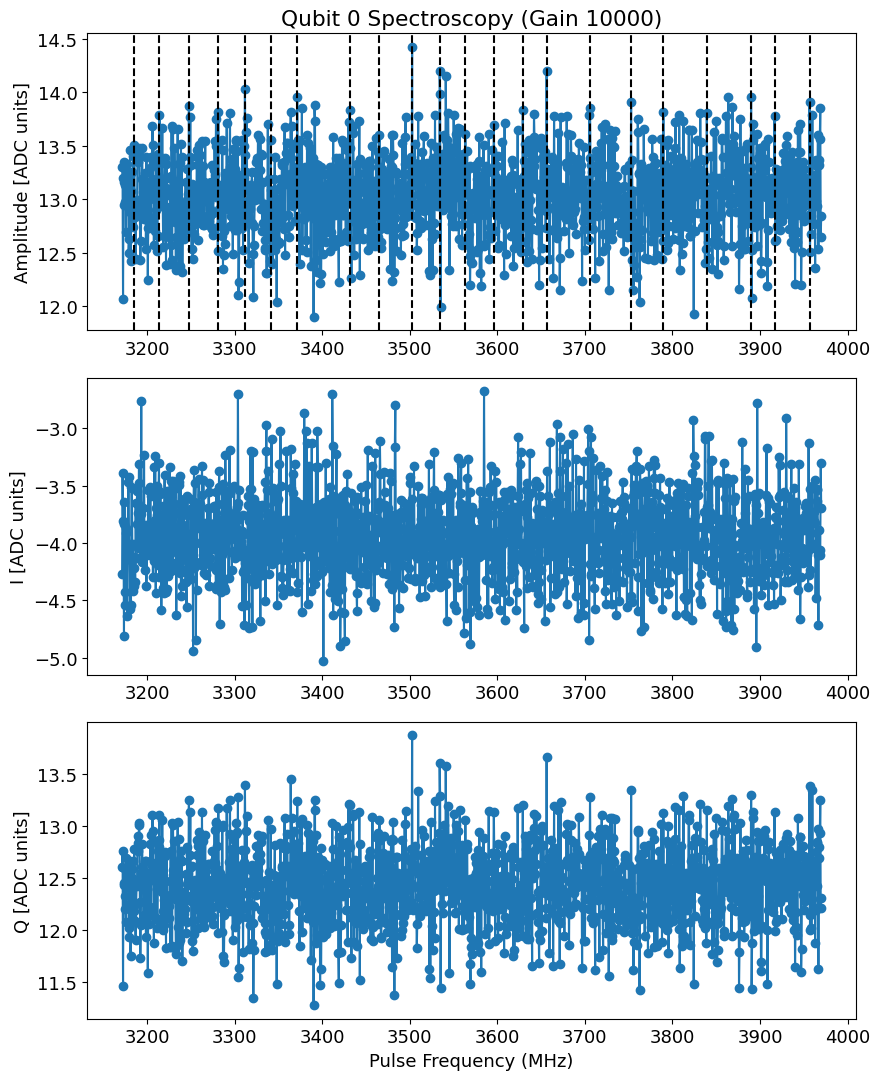

In [24]:
# You may want to update this frequency, which will be the center of the scan. 
#auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(3300), i)
i=0
print('Running qubit spectroscopy for qubit', i)
qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, coarse=True)
qspec.go(analyze=False, display=False, progress=True, save=True)

qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

In [ ]:
qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

#### Updating frequencies 

In [ ]:
# Here, choose which peak you want to save the value for, adjust index accordingly

auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["coarse_peaks_x"][0]), i)
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(qspec.data["coarse_peaks_x"][1]), i)

In [ ]:
3083.359906874908
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(3084.32), i)

### Medium 
(choose your own gain, span)

generator 0 doesn't have a digital mixer, but mixer_freq was defined


  0%|          | 0/20 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_09_04\00000_qubit_spectroscopy_qubit0.h5
Found peak in amps at [MHz] 3546.5796627290206
Found peak in amps at [MHz] 3548.5463293956873
Found peak in amps at [MHz] 3550.5796627290206
Found peak in amps at [MHz] 3552.7463293956876
Found peak in amps at [MHz] 3554.5463293956873
Found peak in amps at [MHz] 3556.9463293956874
Found peak in amps at [MHz] 3560.1796627290205
Found peak in amps at [MHz] 3561.8796627290208
Found peak in amps at [MHz] 3563.646329395687
Found peak in amps at [MHz] 3565.7129960623543
Found peak in amps at [MHz] 3567.5796627290206
Found peak in amps at [MHz] 3569.4463293956874
Found peak in amps at [MHz] 3571.5796627290206
Found peak in amps at [MHz] 3573.646329395687
Found peak in amps at [MHz] 3575.7129960623543
Found peak in amps at [MHz] 3578.146329395687
Found peak in amps at [MHz] 3580.8796627290208
Found peak in amps at [MHz] 3582.5463293956873
Found peak in amps at [MHz] 3584.812996062354
Found peak in amps at [MHz] 3587.11

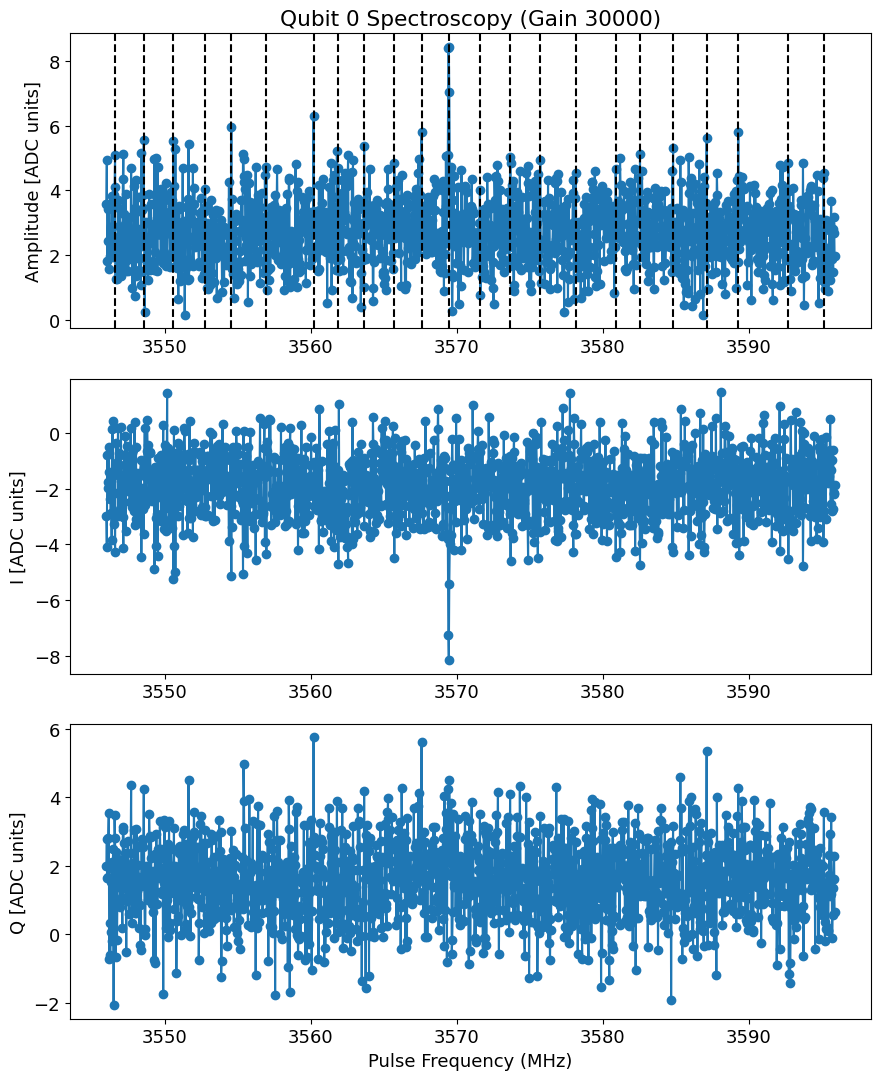

In [25]:
i=0
qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, coarse=True,span=50, gain=30000, reps=5)
qspec.go(analyze=False, display=False, progress=True, save=True)

qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

### Fine

generator 0 doesn't have a digital mixer, but mixer_freq was defined


  0%|          | 0/10 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_09_04\00003_qubit_spectroscopy_qubit0.h5
Found peak in amps at [MHz] 3569.424553597964, HWHM 0.03570644171379832
Found peak in I at [MHz] 3569.4236689713543, HWHM -0.03492916770277306
Found peak in Q at [MHz] 3569.425873748685, HWHM 0.0394178637413693


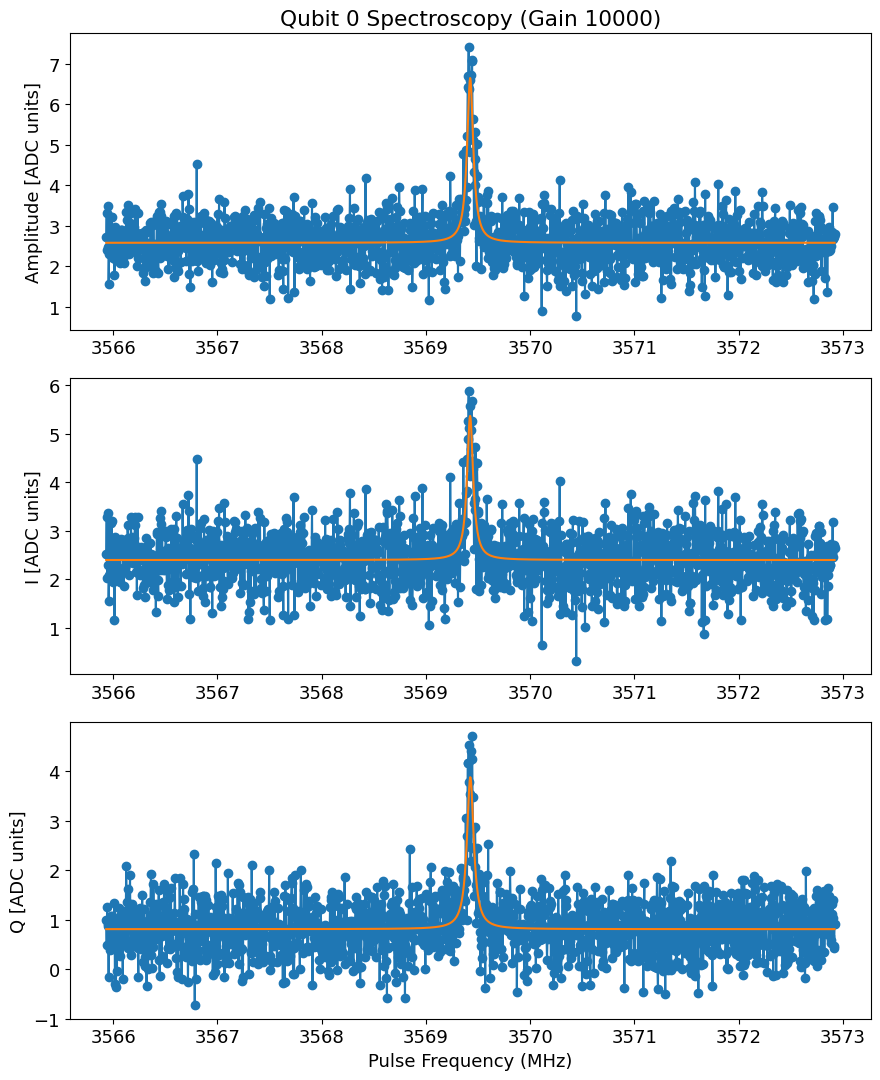

*Set cfg qubit 0 f_ge to 3569.4246 from 3569.4288*
*Set cfg qubit 0 kappa to 0.0714 from 0.0923*


In [34]:
# Fine 
for i in range(1):
    qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, gain=10000, rounds=10, span=7)
    qspec.go(analyze=False, display=False, progress=True, save=True)

    qspec.analyze(fit=True, signs = [1,-1,-1])
    qspec.display(fit=True, signs= [1, -1, -1])

    auto_cfg = config.update_qubit(cfg_file, 'f_ge', round(float(qspec.data["fit_amps"][2]),4), i)
    auto_cfg = config.update_qubit(cfg_file, 'kappa', round(float(2*qspec.data["fit_amps"][3]),4), i)


### EF Spectroscopy

#### Coarse

In [ ]:
i=1
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=True, gain=2000)
qspec.go(analyze=False, display=False, progress=True, save=True)
qspec.analyze()
qspec.display()

#### Fine

In [ ]:
# EF spectroscopy fine 
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i,go=True, im=im)

In [ ]:
auto_cfg = config.update_qubit(cfg_file, 'f_ef', round(float(qspec.data["fit_amps"][2]),4), i)

#### Medium

In [ ]:
#qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=True, span=100, gain=5000, npts=200)
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=True, coarse=True, gain=1000, npts=200, span=50)
#qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=False, gain=300)

qspec.go(analyze=False, display=False, progress=True, save=True)
qspec.analyze(fit=True, coarse=False)
qspec.display(fit=True, coarse=False)

In [ ]:

#auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["fit_amps"][2]), i)
auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(2882.25), i)

In [ ]:
i=1

## Coherent scans

### Rabi

In [ ]:
# We don't need this for initial tuning 
lengthrabi = cfg.make_lengthrabi(soc, expt_path, cfg_path, i, im=im, gain=15000)
lengthrabi.go(analyze=True, display=True, progress=True, save=True)

auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','sigma'), float(lengthrabi.data['pi_length']), i)

#### Amplitude

In [73]:
i=0
amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True, im=im, rounds=1)
#auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','gain'), int(amp_rabi.data['pi_length']), i)


generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 0 doesn't have a digital mixer, but mixer_freq was defined


gauss


TypeError: unsupported operand type(s) for <<: 'float' and 'int'

In [ ]:
amp_rabi.analyze()
amp_rabi.display()

amp_rabi.data

#### Chevron

In [ ]:
amp_chevron = cfg.make_amprabi_chevron(soc, expt_path, cfg_path, i, sigma=0.4, span_f=8)
amp_chevron.go(analyze=True, display=True, progress=True, save=True)

### Ramsey

In [51]:
t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True, im=im)
auto_cfg = config.update_qubit(cfg_file, 'f_ge',round(float(t2r.data['new_freq']),4), i)
auto_cfg = config.update_qubit(cfg_file, 'T2r', round(float(t2r.data['fit_avgi'][3]),2), i)

IndexError: list index out of range

### T1

In [47]:
t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im) 
auto_cfg = config.update_qubit(cfg_file, 'T1', round(float(t1.data['new_t1']),2), i)

generator 0 doesn't have a digital mixer, but mixer_freq was defined


TypeError: RAveragerProgram.acquire() got an unexpected keyword argument 'debug'

### Single Shot

In [42]:
# Single shot 
#config.update_readout(cfg_file, 'gain', 800, i)
#config.update_readout(cfg_file, 'readout_length',5.4,i)
shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, im=im, go=True)
config.update_readout(cfg_file, 'phase', round(float(shot.data['angle']),3), i);
config.update_readout(cfg_file, 'threshold', round(float(shot.data['thresholds'][0]),4), i);
config.update_readout(cfg_file, 'fidelity', round(float(shot.data['fids'][0]),4), i);

KeyError: 'mux_freqs'

In [ ]:
# Check f
shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, im=im, check_f=True, go=True)


In [ ]:
i

### Randomized benchmarking

In [ ]:
rb = cfg.make_rb(soc, expt_path, cfg_path, i, go=True)

### Echo

In [ ]:
t2e = cfg.make_t2e(soc, expt_path, cfg_path, i, ramsey_freq=0.02, step=1.4, npts=400)
t2e.go(analyze=True, display=True, progress=True, save=True)

### Readout opt 

#### 3D Sweep

In [ ]:

shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=20000, npts_f=7, npts_gain=7, npts_len=7)
shotopt.go(analyze=False, display=False, progress=True, save=True)

In [ ]:
i=0
chi = cfg.check_readout(soc, expt_path, cfg_file, i, im=im, check_f=True)

In [ ]:


auto_cfg = config.update_readout(cfg_file, 'chi', round(float(chi.data['chi']),4), i)
auto_cfg = config.update_readout(cfg_file, 'frequency', round(float(chi.data['freq_opt']),4), i)

#### 2D Sweep

In [ ]:
#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=7, npts_len=7, start_gain=6000, span_gain=4500, start_len=12, span_len=25)
#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=6, span_f=0.7, npts_gain=1, npts_len=5, start_len=12, span_len=25)
shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=7, npts_len=7, start_gain=300, span_gain=500, start_len=1, span_len=3, go=True)

#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=7, npts_len=7, go=True, start_gain=540, span_gain=420, start_len=4, span_len=6)

In [ ]:
shotopt.analyze()
shotopt.display()
shotopt.data

#### 1D Sweep

In [ ]:

shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=12, span_f=0.7, npts_gain=1, npts_len=1)

#Length
#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=1, npts_len=10, start_len=2, span_len=6)
#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=10, npts_len=1, start_gain=250, span_gain=250)
shotopt.go(analyze=False, display=False, progress=False, save=True)

shotopt.data

In [ ]:
shotopt.data['fid']

### EF

#### Rabi

In [ ]:
# Rabi EF
#rabi=cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True)
rabief=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, im=im, go=True, pulse_ge=True)
auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ef','gain'), int(rabief.data['pi_length']), i)

#### Qubit Temperature

In [ ]:
rabief=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, im=im, go=True, pulse_ge=True)
rabief_nopulse=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, im=im, go=True, pulse_ge=False, reps=1000, rounds=100, npts=20)

# To measure temperature, use fewer points to get more signal more quickly 
h = 6.62607015e-34
fge = 1e6*rabief.cfg.device.qubit.f_ge[i]
kB = 1.380649e-23

In [ ]:
chan = 'fit_avgi'
print('Qubit temp [mK]:', 1e3*h*fge/(kB*np.log(rabief.data[chan][0]/rabief_nopulse.data[chan][0])))
print('State preparation ratio:', rabief_nopulse.data[chan][0]/rabief.data[chan][0])

In [ ]:
print(rabief.data['fit_avgq'][0])
print(rabief_nopulse.data['fit_avgq'][0])

In [ ]:
print(rabief.data['fit_amps'][0])
print(rabief_nopulse.data['fit_amps'][0])

## Other

In [ ]:
# Need a tuned up pi pulse for this
#for i in range(num_qubits):
for i in range(2,3):
    print(i)
    chi = cfg.make_chi(soc, expt_path, cfg_path, i, go=True)
    chi_val = auto_cfg.device.readout.frequency[i] - chi.data['fit'][0]
    auto_cfg = config.update_readout(cfg_file, 'chi', float(chi_val), i)

## Automated retune once things are working

<Pyro4.core.Proxy at 0x2b168545960; not connected; for PYRO:obj_ae8b7c2c27c24777a78768574a9cbc9a@192.168.137.233:39673>


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\Tuning_2024_06_18\00017_single_shot_qubit2.h5
Unrotated:
Ig -308.4733885274985 +/- 46.28454554460155 	 Qg 242.81490242460083 +/- 47.16062598033876 	 Amp g 392.57471679809623
Ie -316.62684801892374 +/- 51.37616252668432 	 Qe 150.49615612063866 +/- 60.80655365160239 	 Amp e 350.5733217081504
hi
Rotated:
Ig -214.5412452454833 +/- 46.28454554460155 	 Qg -328.64184888144007 +/- 47.16062598033876 	 Amp g 392.47090433265737
Ie -121.87104549725368 +/- 51.37616252668432 	 Qe -328.9163199474002 +/- 60.80655365160239 	 Amp e 350.7684382300298


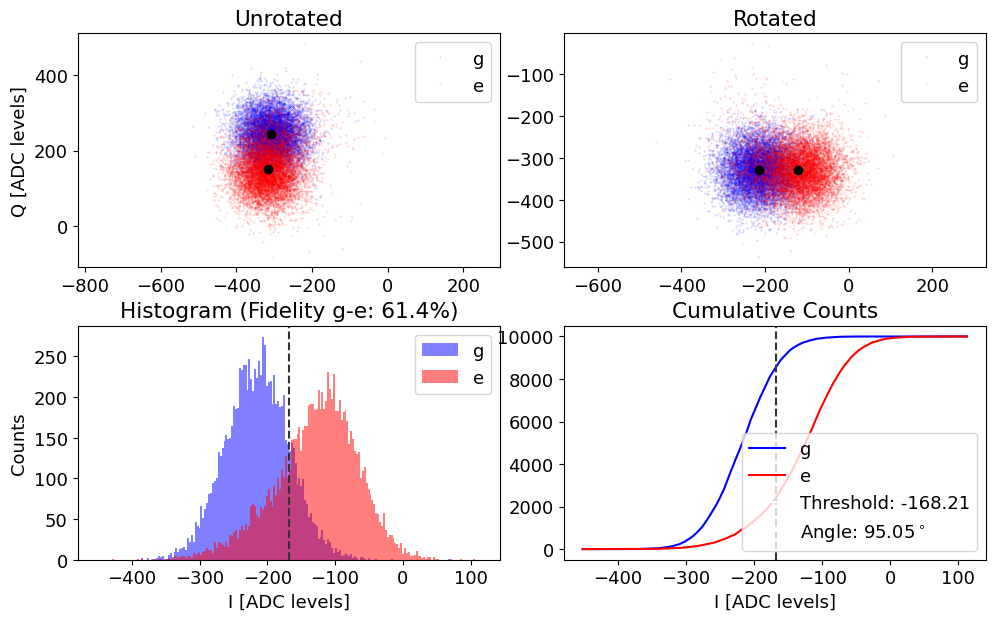

ge fidelity (%): 61.41307065353268
rotation angle (deg): 95.04718542853664
threshold ge: -168.2061453713685
*Set cfg resonator 2 phase to 95.047 from 68.378*
*Set cfg resonator 2 threshold to -168.2061 from -152.9357*
*Set cfg resonator 2 fidelity to 0.6141 from 0.6247*
gauss


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\Tuning_2024_06_18\00006_amp_rabi_qubit2.h5
Pi gain from amps data [dac units]: 9538
	Pi/2 gain from amps data [dac units]: 4769
Pi gain from avgi data [dac units]: 11200
	Pi/2 gain from avgi data [dac units]: 5600
Pi gain from avgq data [dac units]: 9657
	Pi/2 gain from avgq data [dac units]: 4828


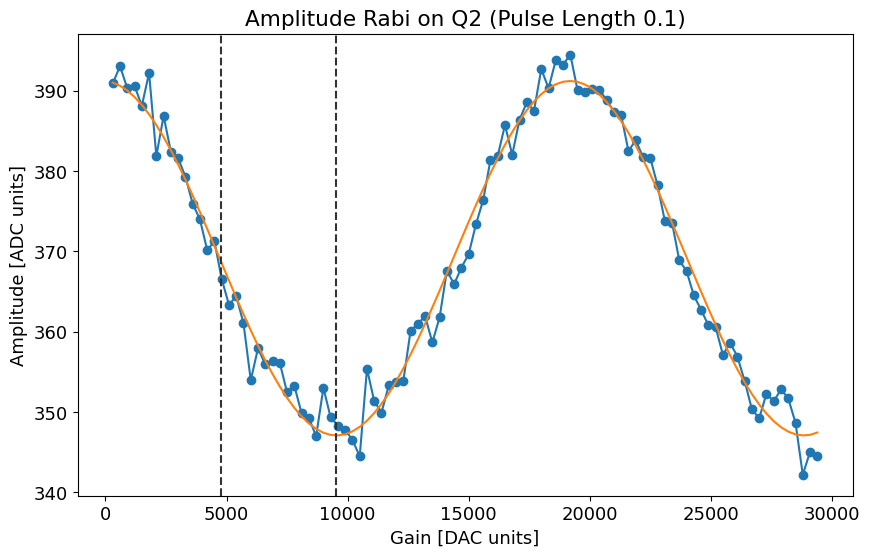

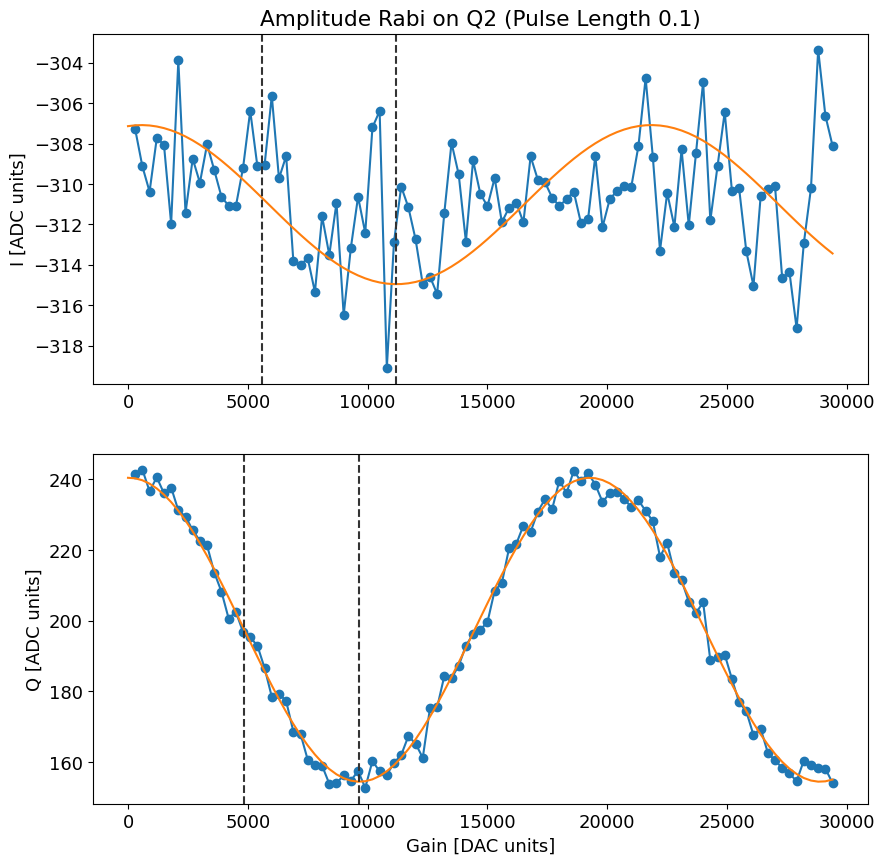

*Set cfg qubit 2 ('pulses', 'pi_ge', 'gain') to 11200 from 9688*


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\Tuning_2024_06_18\00008_ramsey_qubit2.h5
Current pi pulse frequency: 3552.2881
Fit frequency from amps [MHz]: 0.0997360320398979 +/- 0.0003194850136667993
T2 Ramsey from fit amps [us]: 31.00637449969116
Current pi pulse frequency: 3552.2881
Fit frequency from I [MHz]: 0.13575956807720466 +/- 0.0028551822468998816
T2 Ramsey from fit I [us]: 12.40276
Fit frequency from Q [MHz]: 0.10009741720784787 +/- 0.0002453734823416422
T2 Ramsey from fit Q [us]: 36.72251495851822
Suggested new pi pulse frequency from fit 3552.2880:



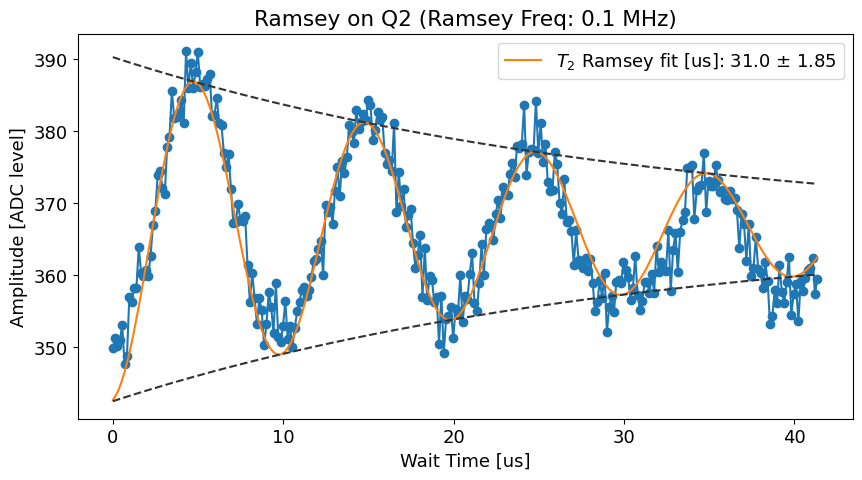

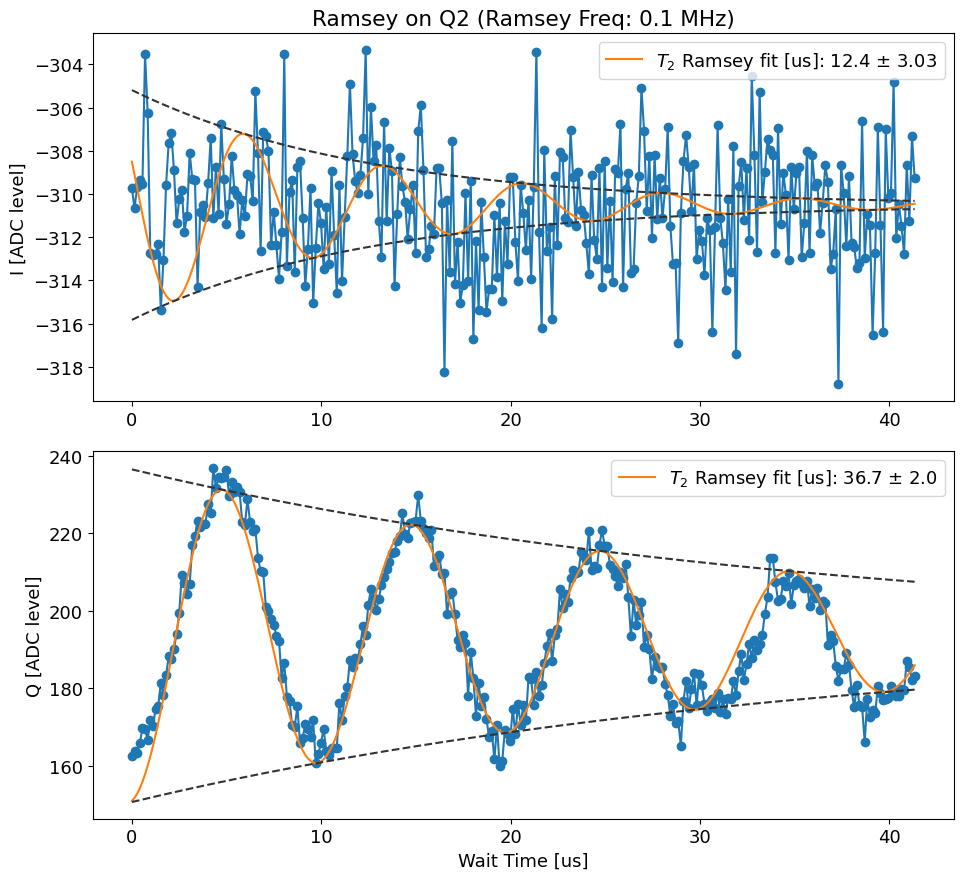

*Set cfg qubit 2 f_ge to 3552.288 from 3552.2881*
*Set cfg qubit 2 T2r to 12.4 from 20.81*


  0%|          | 0/100000 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


t1_amps error:fit ratio= 0.03869221889366153
t1_i error:fit ratio= inf
t1_q error:fit ratio= 0.028190083312760773
t1_amps is better, saving t1_amps to results cfg file
Saving C:\_Data\Coherence\Tuning_2024_06_18\00007_t1_qubit2.h5
Fit T1 amps [us]: 30.483916890373543
Fit T1 avgi [us]: 0.018856595851440394
Fit T1 avgq [us]: 30.56313487583911


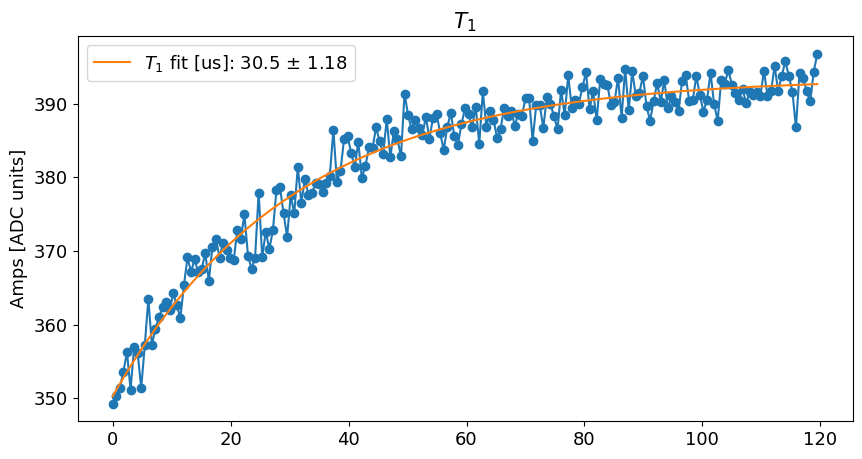

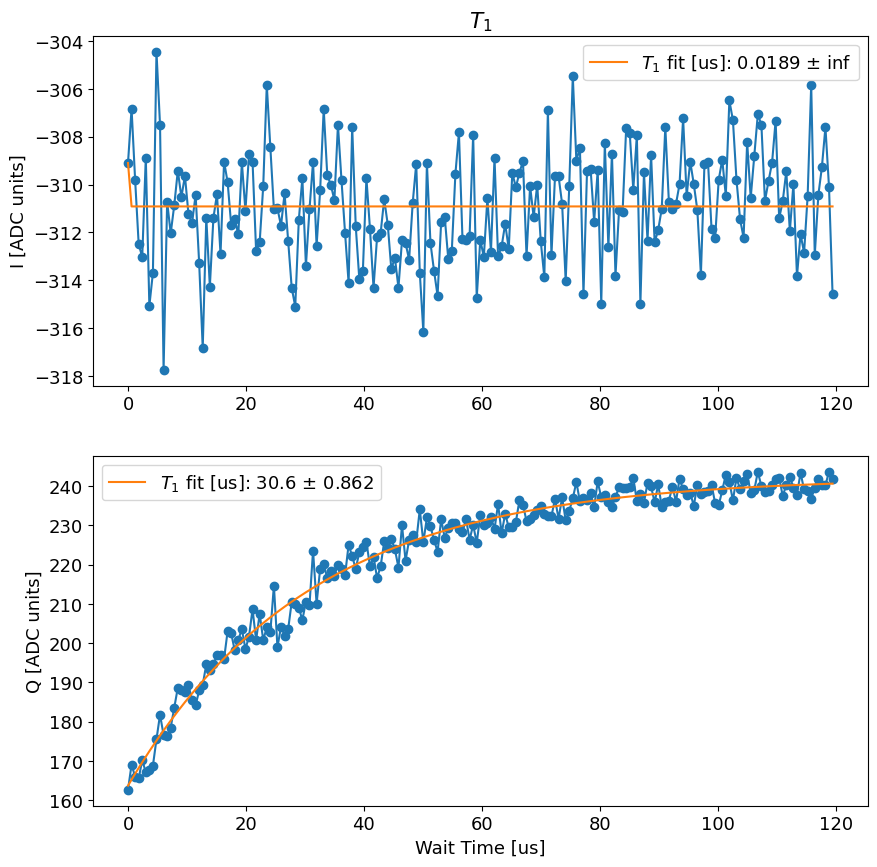

*Set cfg qubit 2 T1 to 30.48 from 40.23*


In [183]:
#for i in range(4):
for i in range(2,3):
    shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True)
    config.update_readout(cfg_file, 'phase', round(float(shot.data['angle']),3), i);
    config.update_readout(cfg_file, 'threshold', round(float(shot.data['thresholds'][0]),4), i);
    config.update_readout(cfg_file, 'fidelity', round(float(shot.data['fids'][0]),4), i);

    amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True)
    auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','gain'), int(amp_rabi.data['pi_length']), i)

    t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True)
    auto_cfg = config.update_qubit(cfg_file, 'f_ge', round(float(t2r.data['new_freq']),4), i)
    config.update_qubit(cfg_file, 'T2r', round(float(t2r.data['fit_avgi'][3]),2), i)


    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True) 
    auto_cfg = config.update_qubit(cfg_file, 'T1', round(float(t1.data['new_t1']),2), i)


#t2e = cfg.make_t2e(soc, expt_path, cfg_path, i,go=True, ramsey_freq=0.02, step=1.4, npts=400)